In [1]:
import os
import datetime

def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n" + "==========" * 8 + "%s" % nowtime)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# 一、准备数据！！！！！
# cifar2数据集为cifar10数据集的子集，
# 只包括前两种类别airplane和automobile。 
# 训练集有airplane和automobile图片各5000张，
# 测试集有airplane和automobile图片各1000张。 
# <cifar2任务的目标是训练一个模型来对飞机airplane和机动车automobile两种图片进行分类。>

# 在Pytorch中构建图片数据管道通常有两种方法。 
# 第一种是使用 torchvision中的datasets.ImageFolder来读取图片然后用 DataLoader来并行加载。
# 第二种是通过继承 torch.utils.data.Dataset 实现用户自定义读取逻辑
# 然后用 DataLoader来并行加载。 
# 第二种方法是读取用户自定义数据集的通用方法，
# 既可以读取图片数据集，也可以读取文本数据集。

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

transform_train = transforms.Compose([transforms.ToTensor()])
transform_valid = transforms.Compose([transforms.ToTensor()])

ds_train = datasets.ImageFolder("../data/cifar2/train",
                               transform = transform_train, target_transform= lambda t:torch.tensor([t]).float())

ds_valid = datasets.ImageFolder("../data/cifar2/test",
                               transform = transform_train, target_transform= lambda t:torch.tensor([t]).float())

print(ds_train.class_to_idx)

{'0_airplane': 0, '1_automobile': 1}


In [3]:
dl_train = DataLoader(ds_train,batch_size = 50,shuffle = True,num_workers=0) 
dl_valid = DataLoader(ds_valid,batch_size = 50,shuffle = True,num_workers=0)

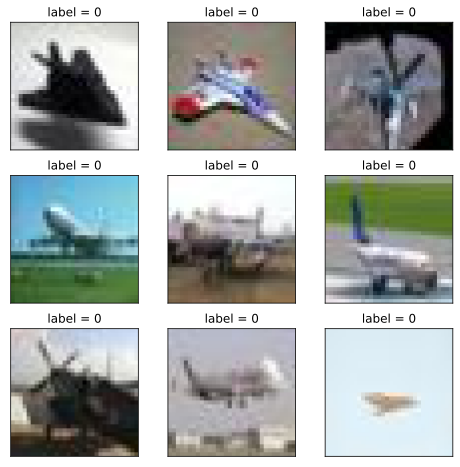

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib import pyplot as plt

# 1. 查看部分样本图片

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [5]:
# Pytorch的图片默认顺序是 Batch,Channel,Width,Height
for x,y in dl_train:
    print(x.shape,y.shape) 
    break
    
    
# 在这里本来是运行失败的。
# 将做以下修改才能运行成功：

#  cell4中的 ax.set_title("label = %d"%label.item())
    
#     改成：
    
#     ax.set_title("label = %d"%label)
    
#     也就是去掉 .item()

torch.Size([50, 3, 32, 32]) torch.Size([50, 1])


In [6]:
# 二、定义模型！！！！！！！！！！！
# 使用Pytorch通常有三种方式构建模型：
# 使用nn.Sequential按层顺序构建模型，
# 继承nn.Module 基类构建自定义模型，
# 继承nn.Module基类构建模型并辅助应用模型容器 (nn.Sequential,nn.ModuleList,nn.ModuleDict)进行封装。 
# 此处选择通过继承nn.Module基类构建自定义模型

# 1. 测试AdaptiveMaxPool2d的效果 
pool= nn.AdaptiveAvgPool2d((1,1))
t = torch.randn(10,8,32,32)
pool(t).shape

torch.Size([10, 8, 1, 1])

In [7]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3)
        self.pool = nn.MaxPool2d(kernel_size = 2,stride = 2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5)
        self.dropout = nn.Dropout2d(p = 0.1)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64,32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.conv1(x)        
        x = self.pool(x)        
        x = self.conv2(x)        
        x = self.pool(x)        
        x = self.dropout(x)        
        x = self.adaptive_pool(x)        
        x = self.flatten(x)        
        x = self.linear1(x)       
        x = self.relu(x)        
        x = self.linear2(x)        
        y = self.sigmoid(x)        
        return y
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [8]:
import torchkeras
torchkeras.summary(net,input_shape= (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
          Sigmoid-11                    [-1, 1]               0
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.011719
Forwar

In [9]:
# 三、训练模型！！！！！！！！
# Pytorch通常需要用户编写自定义训练循环，
# 训练循环的代码风格因人而异。 
# 有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。 
# 此处使用一种较通用的函数形式训练循环

import pandas as pd
from sklearn.metrics import roc_auc_score

model = net
model.optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)
model.loss_func = torch.nn.BCELoss()
model.metric_func = lambda y_pred,y_true:roc_auc_score(y_true.data.numpy(),y_pred.data.numpy())
model.metric_name = "auc"

def train_step(model,features,labels):
    
    # 训练模式，dropout层发生作用
    model.train()
    
    # 梯度清零
    model.optimizer.zero_grad()
    
    # 正向传播求损失
    predictions = model(features)
    loss = model.loss_func(predictions,labels)
    metric = model.metric_func(predictions,labels)

    # 反向传播求梯度
    loss.backward()
    model.optimizer.step()

    return loss.item(),metric.item()

def valid_step(model,features,labels):
    
    # 预测模式，dropout层不发生作用
    model.eval()
    # 关闭梯度计算
    with torch.no_grad():
        predictions = model(features)
        loss = model.loss_func(predictions,labels)
        metric = model.metric_func(predictions,labels)
    
    return loss.item(), metric.item()


# 测试train_step效果
features,labels = next(iter(dl_train))
train_step(model,features,labels)

(0.6911293864250183, 0.3416666666666667)

In [10]:
def train_model(model,epochs,dl_train, dl_valid, log_step_freq):
    metric_name = model.metric_name
    dfhistory = pd.DataFrame(columns = ["epochs", "loss", metric_name, "val_loss", "val_"+ metric_name])
    print("Start training")
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("=========="*8 + "%s"%nowtime)
    
    for epoch in range(1,epochs+1):
        loss_sum = 0.0
        metric_sum = 0.0
        step = 1
        
        for step, (features, labels) in enumerate(dl_train,1):
            loss,metric = train_step(model,features,labels) 
            
            loss_sum += loss
            metric_sum += metric
            
            if step%log_step_freq == 0:
                print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                      (step, loss_sum/step, metric_sum/step))
                      
        val_loss_sum = 0.0
        val_metric_sum = 0.0
        val_step = 1
        
        for val_step, (features, labels) in enumerate(dl_valid,1):
            val_loss,val_metric = valid_step(model,features,labels)
            val_loss_sum += val_loss            
            val_metric_sum += val_metric
        
        info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
        dfhistory.loc[epoch-1] = info
        
        print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
               "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f")               
              %info)
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')        
        print("\n"+"=========="*8 + "%s"%nowtime)
        
    print("Finished Training")
    return dfhistory

epochs = 20
dfhistory = train_model(model, epochs, dl_train, dl_valid, log_step_freq=50)

Start training
================================================================================2021-09-24 10:40:11
[step = 50] loss: 0.693, auc: 0.535
[step = 100] loss: 0.691, auc: 0.597
[step = 150] loss: 0.690, auc: 0.639
[step = 200] loss: 0.689, auc: 0.669

EPOCH = 1, loss = 0.689,auc  = 0.669, val_loss = 0.681, val_auc = 0.825

================================================================================2021-09-24 10:40:17
[step = 50] loss: 0.682, auc: 0.749
[step = 100] loss: 0.680, auc: 0.760
[step = 150] loss: 0.677, auc: 0.768
[step = 200] loss: 0.674, auc: 0.779

EPOCH = 2, loss = 0.674,auc  = 0.779, val_loss = 0.659, val_auc = 0.829

================================================================================2021-09-24 10:40:24
[step = 50] loss: 0.661, auc: 0.787
[step = 100] loss: 0.655, auc: 0.792
[step = 150] loss: 0.650, auc: 0.795
[step = 200] loss: 0.644, auc: 0.797

EPOCH = 3, loss = 0.644,auc  = 0.797, val_loss = 0.610, val_auc = 0.830

======================

In [11]:
# 四、评估模型

dfhistory

,epochs,loss,auc,val_loss,val_auc
0,1.0,0.688645,0.669220,0.681302,0.825212
1,2.0,0.674173,0.779381,0.659161,0.828869
2,3.0,0.643697,0.797301,0.609928,0.830213
3,4.0,0.585993,0.806976,0.536406,0.834001
4,5.0,0.538843,0.812918,0.498752,0.845232
5,6.0,0.515308,0.824887,0.482830,0.854325
6,7.0,0.505755,0.832648,0.466829,0.859824
7,8.0,0.493920,0.843209,0.461407,0.868807
8,9.0,0.480822,0.851311,0.444731,0.877650
9,10.0,0.473236,0.857085,0.436265,0.880954


In [12]:
%matplotlib inline 
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

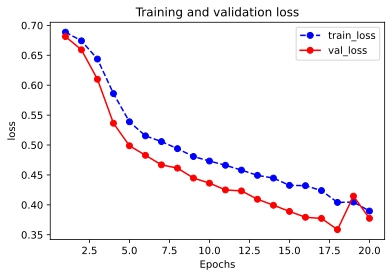

In [13]:
plot_metric(dfhistory,"loss")

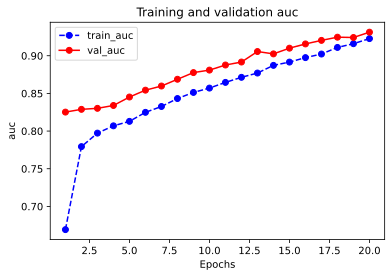

In [14]:
plot_metric(dfhistory,"auc")

In [15]:
# 五、使用模型

def predict(model, dl):
    model.eval()
    result = torch.cat([model.forward(t[0]) for t in dl])
    return(result.data)

# 1. 预测概率
y_pred_probs = predict(model, dl_valid)
y_pred_probs

tensor([[0.6925],
        [0.0072],
        [0.1042],
        ...,
        [0.5957],
        [0.0717],
        [0.0401]])

In [16]:
# 2. 预测类别
y_pred = torch.where(y_pred_probs > 0.5, torch.ones_like(y_pred_probs), 
                    torch.zeros_like(y_pred_probs))
y_pred

tensor([[1.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]])

In [17]:
# 六、保存模型
# 推荐使用保存参数方式保存Pytorch模型
print(model.state_dict().keys())


odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias'])


In [18]:
torch.save(model.state_dict(), "../data/cifar2/model_parameter.pkl")
net_clone = Net() 
net_clone.load_state_dict(torch.load("../data/cifar2/model_parameter.pkl"))

<All keys matched successfully>

In [19]:
predict(net_clone,dl_valid)

tensor([[0.3307],
        [0.8569],
        [0.2074],
        ...,
        [0.2225],
        [0.8821],
        [0.0021]])